### Import packages and data

In [1]:
import numpy as np
import anndata as ad
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from scipy.stats import spearmanr
from sklearn.metrics import silhouette_score
from harmonypy.lisi import compute_lisi
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
DIR="/vast/scratch/users/mueller.h/hackathon"

In [56]:
#adata = ad.read(os.path.join(DIR, "data", "rpca_integrated_atac.h5ad"))
adata = ad.read(os.path.join(DIR, "data", "rpcaproject_integrated.h5ad"))
n = len(adata.obsm)
keys = list(adata.obsm)

## Metrics that do not use labels

### Define a set of markers for a cell type

In [64]:
markers = {
# T cells
"t_cell": ["CD3D", "CD3E", "CD3G", "CD4", "CD8A", "CD8B", "IL7R", "CCR7"],

# B cells
"b_cell": ["MS4A1", "CD19", "CD79A"],

# NK cells
"nk_cell": ["NKG7", "GNLY", "KLRD1", "NCAM1", "FCGR3A"],

# Monocytes
"monocytes": ["CD14", "LYZ", "FCN1", "FCGR3A"],

# Dendritic cells
"dendritic_cell": ["FCER1A", "CLEC9A", "BATF3", "IRF8", "CD1C"],

# Megakaryocytes / Platelets
"megakaryocyte": ["PPBP", "PF4", "ITGA2B", "GP1BA"]
}

### exec

In [67]:
for ct, genes in markers.items():
    sc.tl.score_genes(adata,genes, ctrl_as_ref=True, ctrl_size=50, gene_pool=None, 
                        n_bins=25, score_name=f'score_{ct}', random_state=0, copy=False, use_raw=None)#, layer=None)

t_cell ['CD3D', 'CD3E', 'CD3G', 'CD4', 'CD8A', 'CD8B', 'IL7R', 'CCR7']
b_cell ['MS4A1', 'CD19', 'CD79A']
nk_cell ['NKG7', 'GNLY', 'KLRD1', 'NCAM1', 'FCGR3A']
monocytes ['CD14', 'LYZ', 'FCN1', 'FCGR3A']
dendritic_cell ['FCER1A', 'CLEC9A', 'BATF3', 'IRF8', 'CD1C']
megakaryocyte ['PPBP', 'PF4', 'ITGA2B', 'GP1BA']


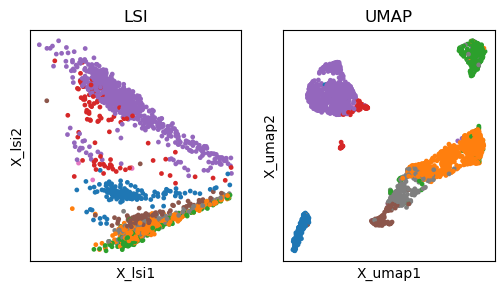

In [74]:
fix,ax = plt.subplots(1,n,figsize=(n*3,3))
for i,emb in enumerate(keys):
    sc.pl.embedding(adata,color='Celltype',cmap='Blues',basis=emb,ax=ax[i], show=False)
    if i < 2:
        ax[i].legend().set_visible(False)
    ax[i].set_title(emb.split("_")[-1].upper())

In [76]:
for emb in keys:
    added = f"{emb}_neigh"
    sc.pp.neighbors(adata, n_neighbors=15,use_rep=emb, knn=True, method='umap', 
                    random_state=0, key_added=added, copy=False)

## Metrics provided by scanpy

### desc

#### Geary’s C
It is a measure of spatial autocorrelation for a numerical variable (e.g., gene expression) on a graph (such as a k-nearest neighbor graph from UMAP or spatial coordinates).
It evaluates whether cells with similar values are close together.

It specifically quantifies local dissimilarity:
Are cells near each other similar or different in value?
The lower the better

#### Moran’s I 

It is a global autocorrelation statistic that quantifies how similar values of a variable (e.g., gene expression) are across a graph structure or spatial map. It is commonly used in spatial data analysis, including 2D spatial grids and single-cell embeddings (e.g., UMAP or spatial transcriptomics).

It evaluates whether high or low values cluster together in the graph.

Closely related to Geary’s C, but emphasizes global rather than local similarity.

The closer to 2 the better

### exec

#### Geary's C

In [ ]:
for emb in keys:
    added = f"{emb}_neigh"
    adata.uns['neighbors'] = adata.uns[added]
    adata.obsp['connectivities'] = adata.obsp[f'{added}_connectivities']
    adata.obsp['distances'] = adata.obsp[f'{added}_distances']
    print(emb, sc.metrics.gearys_c(adata, vals=adata.obs["score_b_cell"],obsm=added))

X_lsi 0.8215089167979284
X_umap 0.7964878007761113


#### Moran's I

In [82]:
for emb in keys:
    added = f"{emb}_neigh"
    adata.uns['neighbors'] = adata.uns[added]
    adata.obsp['connectivities'] = adata.obsp[f'{added}_connectivities']
    adata.obsp['distances'] = adata.obsp[f'{added}_distances']
    print(emb, sc.metrics.morans_i(adata, vals=adata.obs["score_b_cell"],obsm=added))

X_lsi 0.20488093778866487
X_umap 0.2051331612477272


## Custom metric

This function evaluates how spatially localized the expression of a gene or gene set is within a low-dimensional embedding (e.g., UMAP), using three neighborhood-based scores:

It will give as output:
local_corr	Correlation between a cell’s expression and its nearest neighbors → local coherence
distant_corr	Correlation with farthest cells in the embedding → checks for global smearing (overintegration)
random_corr	Correlation with random cells → acts as a baseline control

#### func def

In [86]:
def marker_spatial_expression_scores(
    adata,
    genes,
    embedding='X_umap',
    n_neighbors=15,
    n_distant=15,
    n_random=15,
    agg='mean',
    seed=42
):
    """
    Evaluate whether a gene or gene set is:
    - Locally clustered (local_corr)
    - Globally exclusive (distant_corr)
    - Different from random placement (random_corr)

    Parameters:
    - genes: str or list of genes
    - embedding: key in adata.obsm (e.g., 'X_umap')
    - n_neighbors: # of nearest neighbors for local
    - n_distant: # of farthest cells for distant
    - n_random: # of random cells for random
    - agg: 'mean' or 'sum' for combining gene expressions
    - seed: for reproducibility of random sampling

    Returns:
    - Dictionary of local_corr, distant_corr, random_corr
    """

    if embedding not in adata.obsm:
        raise ValueError(f"{embedding} not found in adata.obsm")

    if isinstance(genes, str):
        genes = [genes]
    for g in genes:
        if g not in adata.var_names:
            raise ValueError(f"Gene '{g}' not found in adata.var_names")

    coords = adata.obsm[embedding]
    expr_matrix = adata[:, genes].X
    if hasattr(expr_matrix, 'toarray'):
        expr_matrix = expr_matrix.toarray()

    # Combine gene expression
    if agg == 'mean':
        expr = expr_matrix.mean(axis=1)
    elif agg == 'sum':
        expr = expr_matrix.sum(axis=1)
    else:
        raise ValueError("agg must be 'mean' or 'sum'")

    # Nearest neighbors (local structure)
    nn = NearestNeighbors(n_neighbors=n_neighbors).fit(coords)
    local_neighbors = nn.kneighbors(coords, return_distance=False)
    local_means = np.array([expr[neigh].mean() for neigh in local_neighbors])
    local_corr, _ = spearmanr(expr, local_means)

    # Farthest neighbors (distant structure)
    dist_matrix = pairwise_distances(coords)
    np.fill_diagonal(dist_matrix, -np.inf)
    distant_neighbors = np.argsort(dist_matrix, axis=1)[:, -n_distant:]
    distant_means = np.array([expr[neigh].mean() for neigh in distant_neighbors])
    distant_corr, _ = spearmanr(expr, distant_means)

    # Random neighbors (control)
    np.random.seed(seed)
    random_neighbors = np.array([np.random.choice(len(expr), size=n_random, replace=False)
                                 for _ in range(len(expr))])
    random_means = np.array([expr[neigh].mean() for neigh in random_neighbors])
    random_corr, _ = spearmanr(expr, random_means)

    return {
        "local_corr": local_corr,
        "distant_corr": distant_corr,
        "random_corr": random_corr
    }


In [85]:
def marker_spatial_score_from_obs(
    adata,
    score_key,
    embedding='X_umap',
    n_neighbors=15,
    n_distant=15,
    n_random=15,
    seed=42
):
    """
    Evaluate whether a precomputed gene score is:
    - Locally clustered (local_corr)
    - Globally exclusive (distant_corr)
    - Different from random placement (random_corr)

    Parameters:
    - score_key: str, name of the column in adata.obs with the gene score
    - embedding: str, key in adata.obsm (e.g., 'X_umap')
    - n_neighbors: int, number of nearest neighbors for local score
    - n_distant: int, number of farthest cells for distant score
    - n_random: int, number of random neighbors for control
    - seed: int, random seed for reproducibility

    Returns:
    - dict with local_corr, distant_corr, and random_corr (Spearman values)
    """

    if embedding not in adata.obsm:
        raise ValueError(f"{embedding} not found in adata.obsm")
    if score_key not in adata.obs:
        raise ValueError(f"{score_key} not found in adata.obs")

    coords = adata.obsm[embedding]
    expr = adata.obs[score_key].values

    # Local correlation
    nn = NearestNeighbors(n_neighbors=n_neighbors).fit(coords)
    local_neighbors = nn.kneighbors(coords, return_distance=False)
    local_means = np.array([expr[neigh].mean() for neigh in local_neighbors])
    local_corr, _ = spearmanr(expr, local_means)

    # Distant correlation
    dist_matrix = pairwise_distances(coords)
    np.fill_diagonal(dist_matrix, -np.inf)
    distant_neighbors = np.argsort(dist_matrix, axis=1)[:, -n_distant:]
    distant_means = np.array([expr[neigh].mean() for neigh in distant_neighbors])
    distant_corr, _ = spearmanr(expr, distant_means)

    # Random correlation
    np.random.seed(seed)
    random_neighbors = np.array([np.random.choice(len(expr), size=n_random, replace=False)
                                 for _ in range(len(expr))])
    random_means = np.array([expr[neigh].mean() for neigh in random_neighbors])
    random_corr, _ = spearmanr(expr, random_means)

    return {
        "local_corr": local_corr,
        "distant_corr": distant_corr,
        "random_corr": random_corr
    }


#### exec

In [87]:
for emb in keys:
    print("")
    print(emb)
    scores = marker_spatial_expression_scores(adata, b_cell_markers, embedding = emb)
    print("Local correlation:", scores["local_corr"])
    print("Distant correlation:", scores["distant_corr"])
    print("Random correlation:", scores["random_corr"])



X_lsi
Local correlation: 0.4302626562390693
Distant correlation: -0.003653022932081565
Random correlation: 0.007415733978409212

X_umap
Local correlation: 0.4169788037251771
Distant correlation: -0.13571114086477518
Random correlation: 0.007415733978409212


## Metrics that use labels

#### func def

In [88]:

def evaluate_embedding_metrics_withlabels(
    adata,
    label_key,
    embedding_key='X_scVI',
    clisi_key=None,
    knn_k=30
):
    """
    Evaluate embedding quality using:
    - Silhouette Score (how well cell types are separated)
    - kNN Purity (proportion of same-label neighbors)
    - cLISI (Local Inverse Simpson's Index for cell type conservation)

    Parameters
    ----------
    adata : AnnData
        AnnData object with embedding and annotations.
    label_key : str
        Column in adata.obs with labels for silhouette and kNN purity (e.g., 'cell_type').
    embedding_key : str
        Key in adata.obsm for the embedding (e.g., 'X_scVI', 'X_integrated').
    clisi_key : str or None
        Column in adata.obs with biological labels to use for cLISI (e.g., 'cell_type').
        If None, cLISI will not be computed.
    knn_k : int
        Number of neighbors for computing kNN purity.

    Returns
    -------
    dict
        Dictionary with:
        - 'silhouette': Silhouette score (higher = better conservation)
        - 'knn_purity': Mean kNN purity (higher = better conservation)
        - 'cLISI_mean': Mean cLISI (≈ 1 = good conservation; higher = overintegration)
    """
    if embedding_key not in adata.obsm:
        raise ValueError(f"Embedding '{embedding_key}' not found in adata.obsm.")
    if label_key not in adata.obs:
        raise ValueError(f"Label '{label_key}' not found in adata.obs.")

    X = adata.obsm[embedding_key]
    labels = adata.obs[label_key]

    # 1. Silhouette Score
    sil = silhouette_score(X, labels)

    # 2. kNN Purity
    nn = NearestNeighbors(n_neighbors=knn_k + 1).fit(X)
    neighbors = nn.kneighbors(X, return_distance=False)[:, 1:]  # exclude self
    purity_scores = np.array([
        np.mean(labels.iloc[neighbors[i]] == labels.iloc[i])
        for i in range(len(labels))
    ])
    knn_purity = purity_scores.mean()

    # 3. cLISI
    if clisi_key:
        if clisi_key not in adata.obs:
            raise ValueError(f"clisi_key '{clisi_key}' not found in adata.obs.")
        metadata_df = adata.obs[[clisi_key]].copy()
        clisi_scores = compute_lisi(X, metadata_df, [clisi_key])
        clisi_mean = float(np.mean(clisi_scores[:, 0]))
        adata.obs["cLISI"] = clisi_scores[:, 0]  # Optional: store per-cell
    else:
        clisi_mean = None

    return {
        'silhouette': sil,
        'knn_purity': knn_purity,
        'cLISI_mean': clisi_mean
    }


#### exec

In [89]:
for emb in keys:
    results = evaluate_embedding_metrics_withlabels(
        adata,
        label_key="Celltype",         # for silhouette + kNN purity
        embedding_key=emb,  # or "X_scVI"
        clisi_key="Celltype",         # used to compute cLISI
        knn_k=15
    )
    print("")
    print(emb)
    print(results)



X_lsi
{'silhouette': 0.010004751524984376, 'knn_purity': 0.8811288854207308, 'cLISI_mean': 1.2275315092145922}

X_umap
{'silhouette': 0.3001523731585448, 'knn_purity': 0.8952789699570817, 'cLISI_mean': 1.153234040482487}
